# 1 . Download Data

## Register and download the dataset from the following link

In [1]:
!wget http://download.cs.stanford.edu/deep/MRNet-v1.0.zip

--2019-05-29 11:44:06--  http://download.cs.stanford.edu/deep/MRNet-v1.0.zip
Resolving download.cs.stanford.edu (download.cs.stanford.edu)... 171.64.64.22
Connecting to download.cs.stanford.edu (download.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6087523606 (5.7G) [application/zip]
Saving to: ‘MRNet-v1.0.zip’

MRNet-v1.0.zip      100%[===================>]   5.67G  13.3MB/s    in 7m 26s  

2019-05-29 11:51:37 (13.0 MB/s) - ‘MRNet-v1.0.zip’ saved [6087523606/6087523606]



## Unzipping Data

In [3]:
!unzip MRNet-v1.0.zip

Archive:  MRNet-v1.0.zip
warning [MRNet-v1.0.zip]:  4294967296 extra bytes at beginning or within zipfile
  (attempting to process anyway)
file #1:  bad zipfile offset (local header sig):  4294967296
  (attempting to re-compensate)
replace MRNet-v1.0/valid-abnormal.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: MRNet-v1.0/valid-abnormal.csv  
  inflating: MRNet-v1.0/valid/axial/1139.npy  
  inflating: MRNet-v1.0/valid/axial/1138.npy  
  inflating: MRNet-v1.0/valid/axial/1249.npy  
  inflating: MRNet-v1.0/valid/axial/1248.npy  
  inflating: MRNet-v1.0/valid/axial/1207.npy  
  inflating: MRNet-v1.0/valid/axial/1213.npy  
  inflating: MRNet-v1.0/valid/axial/1171.npy  
  inflating: MRNet-v1.0/valid/axial/1165.npy  
  inflating: MRNet-v1.0/valid/axial/1159.npy  
  inflating: MRNet-v1.0/valid/axial/1158.npy  
  inflating: MRNet-v1.0/valid/axial/1164.npy  
  inflating: MRNet-v1.0/valid/axial/1170.npy  
  inflating: MRNet-v1.0/valid/axial/1212.npy  
  inflating: MRNet-v1.0/valid/axi

# 2. Build Model

In [4]:
from keras.applications import ResNet50
import numpy as np
import cv2
import csv
import os
import keras
import matplotlib.pyplot as plt
from keras.applications.resnet50 import ResNet50
from keras.layers import Flatten, Input
from keras.models import Model
from tqdm import tqdm
from keras.applications.imagenet_utils import preprocess_input
from keras.applications.xception import Xception
WIDTH = 128
HEIGHT = 128

Using TensorFlow backend.


## 1. Extracting Labels (Validation and Training)

In [0]:
train_acl_lbl = []
train_abnormal_lbl = []
train_meniscus_lbl = []

valid_acl_lbl = []
valid_abnormal_lbl = []
valid_meniscus_lbl = []

i = 0
csvs = ["train-acl.csv", "train-abnormal.csv","train-meniscus.csv","valid-acl.csv", "valid-abnormal.csv","valid-meniscus.csv"]
for c in csvs:
  with open('/content/MRNet-v1.0/'+ c, newline='') as csvfile:
    read = csv.reader(csvfile, delimiter=' ', quotechar='|')
    if i == 0:
       for row in read:
          train_acl_lbl.append(', '.join(row)[5])
       i+=1
    elif i == 1:
      for row in read:
        train_abnormal_lbl.append(', '.join(row)[5])
      i+=1
    elif i == 2:
      for row in read:
        train_meniscus_lbl.append(', '.join(row)[5])
      i+=1
    elif i == 3:
      for row in read:
        valid_acl_lbl.append(', '.join(row)[5])
      i+=1
    elif i == 4:
      for row in read:
        valid_abnormal_lbl.append(', '.join(row)[5])
      i+=1
    elif i == 5:
      for row in read:
        valid_meniscus_lbl.append(', '.join(row)[5])
      i+=1  

## 2. Enconding Labels

In [6]:
def getTheLabels(a,b,c):
  labels = [0] * len(a)
  for i in tqdm(range(len(labels))):
    labels[i] = int(str(a[i]) + str(b[i]) + str(c[i]),2)
  return np.array(labels)

#Encoding all labels to be a number from (0-7) (Abnormal,ACL,Meniscus)
train_label = getTheLabels(train_abnormal_lbl,train_acl_lbl,train_meniscus_lbl)
valid_label = getTheLabels(valid_abnormal_lbl,valid_acl_lbl,valid_meniscus_lbl)
del(train_abnormal_lbl)
del(train_acl_lbl)
del(train_meniscus_lbl)
del(valid_abnormal_lbl)
del(valid_acl_lbl)
del(valid_meniscus_lbl)

100%|██████████| 120/120 [00:00<00:00, 58950.16it/s]


## 3. Getting Views data and label

In [7]:
train_axial = np.zeros([38778,WIDTH,HEIGHT,3], dtype='uint8')
train_coronal = np.zeros([33649,WIDTH,HEIGHT,3], dtype='uint8') 
train_sagittal = np.zeros([34370,WIDTH,HEIGHT,3],dtype='uint8')

train_axial_lbl = np.zeros([38778], dtype='uint8')
train_coronal_lbl = np.zeros([33649], dtype='uint8')
train_sagittal_lbl = np.zeros([34370],dtype='uint8')

i = 0

train_axial_idx = 0
train_sagittal_idx = 0
train_coronal_idx = 0

dir_train="/content/MRNet-v1.0/train/"

def to_rgb(img,wid,hei):# -> Resizing image to fit as (WIDTH,HEIGHT,3)
    img = cv2.resize(img, (wid,hei), interpolation = cv2.INTER_AREA) 
    img_rgb = np.asarray(np.dstack((img, img, img)), dtype=np.uint8)
    return img_rgb

def getTheDataLabelPerView_(obj,save_in,idx):
  global train_axial_idx , train_sagittal_idx , train_coronal_idx
  for j in tqdm(range(len(obj))): # 0 -> s (For every view)
    if (save_in == 'train_axial'):
      train_axial[train_axial_idx] = to_rgb(obj[j],WIDTH,HEIGHT) # -> save each image as (WIDTH,HEIGHT,3)
      train_axial_lbl[train_axial_idx] = train_label[idx] # -> Giving all images the same label as patient.
      train_axial_idx += 1
    elif(save_in == 'train_coronal'):
      train_coronal[train_coronal_idx] = to_rgb(obj[j],WIDTH,HEIGHT) # -> save each image as (WIDTH,HEIGHT,3)
      train_coronal_lbl[train_coronal_idx] = train_label[idx] # -> Giving all images the same label as patient.
      train_coronal_idx += 1
    else:
      train_sagittal[train_sagittal_idx] = to_rgb(obj[j],WIDTH,HEIGHT) # -> save each image as (WIDTH,HEIGHT,3)
      train_sagittal_lbl[train_sagittal_idx] = train_label[idx] # -> Giving all images the same label as patient.
      train_sagittal_idx += 1
      
      
for folder in sorted(os.listdir(dir_train)):
  idx = 0
  if folder == ".DS_Store":
    continue;
  type_dir = os.path.join(dir_train,folder)
  os.chdir(type_dir)
  for img in sorted(os.listdir(type_dir)):
    if img == ".DS_Store":
      continue
    img_dir=os.path.join(type_dir,img)
    if i == 0:
      getTheDataLabelPerView_(np.load(img_dir).astype('uint8'),'train_axial',idx)
    elif i == 1:
      getTheDataLabelPerView_(np.load(img_dir).astype('uint8'),'train_coronal',idx)
    elif i == 2:
      getTheDataLabelPerView_(np.load(img_dir).astype('uint8'),'train_sagittal',idx)
    idx += 1 
  i+=1

100%|██████████| 34/34 [00:00<00:00, 9040.02it/s]


# 3. Model Selection

In [0]:
model_sagittal = Xception(weights=None, pooling='avg', include_top = False, input_shape = (WIDTH, HEIGHT, 3)) 
model_coronal = Xception( weights=None, pooling='avg', include_top = False, input_shape = (WIDTH, HEIGHT, 3)) 
model_axial = Xception(   weights=None, pooling='avg', include_top = False, input_shape = (WIDTH, HEIGHT, 3)) 

In [0]:
model_sagittal.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])
model_coronal.compile( optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])
model_axial.compile(   optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])


In [16]:
history_sag = model_sagittal.fit(train_sagittal, train_sagittal_lbl, epochs=10, batch_size=5, verbose =1, validation_split=0.2, callbacks =[keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')])

Train on 27496 samples, validate on 6874 samples
Epoch 1/10
27496/27496 [==============================] - 430s 16ms/step - loss: 1.8613 - acc: 0.3666 - val_loss: 1.4459 - val_acc: 0.4169
Epoch 2/10
27496/27496 [==============================] - 414s 15ms/step - loss: 1.3330 - acc: 0.4178 - val_loss: 1.5017 - val_acc: 0.4050
Epoch 3/10
27496/27496 [==============================] - 414s 15ms/step - loss: 1.3053 - acc: 0.4272 - val_loss: 1.4161 - val_acc: 0.4296
Epoch 4/10
27496/27496 [==============================] - 415s 15ms/step - loss: 1.2560 - acc: 0.4518 - val_loss: 1.4189 - val_acc: 0.4217
Epoch 5/10
27496/27496 [==============================] - 415s 15ms/step - loss: 1.2221 - acc: 0.4747 - val_loss: 1.4184 - val_acc: 0.4388
Epoch 6/10
27496/27496 [==============================] - 416s 15ms/step - loss: 1.1780 - acc: 0.5021 - val_loss: 1.6048 - val_acc: 0.3827
Epoch 7/10
27496/27496 [==============================] - 415s 15ms/step - loss: 1.1287 - acc: 0.5252 - val_loss: 1.6

In [0]:
history_cor = model_coronal.fit(train_coronal, train_coronal_lbl, epochs=10, batch_size=5, verbose =1, validation_split=0.2, callbacks =[keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')])


Train on 26919 samples, validate on 6730 samples
Epoch 1/10
26919/26919 [==============================] - 402s 15ms/step - loss: 1.1809 - acc: 0.5082 - val_loss: 1.6909 - val_acc: 0.4079
Epoch 2/10
26919/26919 [==============================] - 402s 15ms/step - loss: 1.1354 - acc: 0.5380 - val_loss: 1.8197 - val_acc: 0.3737
Epoch 3/10
26919/26919 [==============================] - 403s 15ms/step - loss: 1.1186 - acc: 0.5408 - val_loss: 1.7169 - val_acc: 0.4116
Epoch 4/10
26919/26919 [==============================] - 400s 15ms/step - loss: 1.0634 - acc: 0.5651 - val_loss: 2.0583 - val_acc: 0.3952
Epoch 5/10
26919/26919 [==============================] - 401s 15ms/step - loss: 1.0893 - acc: 0.5591 - val_loss: 1.9831 - val_acc: 0.4070
Epoch 6/10
26919/26919 [==============================] - 404s 15ms/step - loss: 1.0360 - acc: 0.5786 - val_loss: 1.6425 - val_acc: 0.4021
Epoch 7/10
26919/26919 [==============================] - 405s 15ms/step - loss: 1.0359 - acc: 0.5820 - val_loss: 1.9

In [0]:
history_ax = model_axial.fit(train_axial, train_axial_lbl, epochs=10, batch_size=5, verbose =1, validation_split=0.2, callbacks =[keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')])

Train on 31022 samples, validate on 7756 samples
Epoch 1/10
31022/31022 [==============================] - 456s 15ms/step - loss: 1.1209 - acc: 0.5257 - val_loss: 1.9477 - val_acc: 0.3814
Epoch 2/10
31022/31022 [==============================] - 461s 15ms/step - loss: 0.9849 - acc: 0.5920 - val_loss: 1.7284 - val_acc: 0.3804
Epoch 3/10
31022/31022 [==============================] - 456s 15ms/step - loss: 1.0290 - acc: 0.5779 - val_loss: 2.7767 - val_acc: 0.3872
Epoch 4/10
31022/31022 [==============================] - 463s 15ms/step - loss: 0.9483 - acc: 0.6225 - val_loss: 2.8201 - val_acc: 0.4054
Epoch 5/10
31022/31022 [==============================] - 462s 15ms/step - loss: 0.8702 - acc: 0.6664 - val_loss: 2.5005 - val_acc: 0.3952
Epoch 6/10
31022/31022 [==============================] - 462s 15ms/step - loss: 0.8405 - acc: 0.6757 - val_loss: 3.8975 - val_acc: 0.3880
Epoch 7/10
31022/31022 [==============================] - 463s 15ms/step - loss: 0.8047 - acc: 0.7009 - val_loss: 2.2

In [0]:
#   abc
# ['101'] --> Axial --> list
# ['111'] --> Coronal --> list
# ['110'] --> Sagittal
#   '111'

def getMajorityVoting(bits_string):
  return int(np.argmax(np.bincount(np.array(bits_string).astype(int))))
  
	
def getPatientCase(axial_results,coronal_results,sagittal_results):
  voting = []
  voting.append(getMajorityVoting(axial_results))
  voting.append(getMajorityVoting(coronal_results)) 
  voting.append(getMajorityVoting(sagittal_results)) 
  return int(getMajorityVoting(voting))

def evaluate_patients(numberOfPatients,patients_axials,patients_coronals,patients_sagittals):
  for i in tqdm(range(numberOfPatients)):
    
    axial_results    = np.empty([len(patients_axials[i]   )])
    coronal_results  = np.empty([len(patients_coronals[i] )])
    sagittal_results = np.empty([len(patients_sagittals[i])])
    
    for j in range(len(axial_results)):
      a = model_axial.predict(to_rgb(  patients_axials[i][j]  ,  WIDTH,HEIGHT)[np.newaxis, :]).argmax(axis=-1)
      #print("Axial #",i," Image #",j," Prediction is: ",a)
      axial_results[j] = a
    
    for j in range(len(coronal_results)):
      b = model_coronal.predict(to_rgb(patients_coronals[i][j],  WIDTH,HEIGHT)[np.newaxis, :]).argmax(axis=-1)
      #print("Coronal #",i," Image #",j," Prediction is: ",b)
      coronal_results[j] = b
    
    for j in range(len(sagittal_results)):
      c = model_sagittal.predict(to_rgb(patients_sagittals[i][j],WIDTH,HEIGHT)[np.newaxis, :]).argmax(axis=-1)
      #print("Sagittal #",i," Image #",j," Prediction is: ",c)
      sagittal_results[j] = c
    print("------------------------------------------------------------")
    if(int(getPatientCase(axial_results,coronal_results,sagittal_results) == int(valid_label[i]))):
      print("Correct!")
    else:
      print("Wrong!")

In [0]:
valid_ = []

dir_valid="/content/MRNet-v1.0/valid/"
i = 0
for folder in sorted(os.listdir(dir_valid)):
  if folder == ".DS_Store":
    continue;
  type_dir=os.path.join(dir_valid,folder)

  os.chdir(type_dir)
  for img in sorted(os.listdir(type_dir)):
    if img == ".DS_Store":
      continue;
    img_dir=os.path.join(type_dir,img)  
  
    if i==0:
      valid_.append(np.load(img_dir).astype('uint8'))
      
    elif i==1:
      valid_.append(np.load(img_dir).astype('uint8'))
      
    elif i==2:
      valid_.append(np.load(img_dir).astype('uint8'))
  i+=1
  
evaluate_patients(120, valid_[:120],valid_[120:240],valid_[240:])



  1%|          | 1/120 [00:07<14:03,  7.09s/it]

------------------------------------------------------------
Correct!


  2%|▏         | 2/120 [00:07<10:05,  5.13s/it]

------------------------------------------------------------
Correct!


  2%|▎         | 3/120 [00:08<07:20,  3.76s/it]

------------------------------------------------------------
Correct!


  3%|▎         | 4/120 [00:08<05:23,  2.79s/it]

------------------------------------------------------------
Correct!


  4%|▍         | 5/120 [00:09<04:08,  2.16s/it]

------------------------------------------------------------
Wrong!


  5%|▌         | 6/120 [00:10<03:16,  1.72s/it]

------------------------------------------------------------
Wrong!


  6%|▌         | 7/120 [00:11<02:46,  1.48s/it]

------------------------------------------------------------
Correct!


  7%|▋         | 8/120 [00:11<02:13,  1.19s/it]

------------------------------------------------------------
Wrong!


  8%|▊         | 9/120 [00:12<01:49,  1.01it/s]

------------------------------------------------------------
Correct!


  8%|▊         | 10/120 [00:12<01:39,  1.11it/s]

------------------------------------------------------------
Correct!


  9%|▉         | 11/120 [00:13<01:39,  1.10it/s]

------------------------------------------------------------
Wrong!


 10%|█         | 12/120 [00:14<01:33,  1.16it/s]

------------------------------------------------------------
Wrong!


 11%|█         | 13/120 [00:15<01:30,  1.18it/s]

------------------------------------------------------------
Wrong!


 12%|█▏        | 14/120 [00:16<01:29,  1.18it/s]

------------------------------------------------------------
Correct!


 12%|█▎        | 15/120 [00:17<01:30,  1.17it/s]

------------------------------------------------------------
Wrong!


 13%|█▎        | 16/120 [00:17<01:31,  1.14it/s]

------------------------------------------------------------
Wrong!


 14%|█▍        | 17/120 [00:18<01:20,  1.28it/s]

------------------------------------------------------------
Correct!


 15%|█▌        | 18/120 [00:19<01:14,  1.37it/s]

------------------------------------------------------------
Correct!


 16%|█▌        | 19/120 [00:19<01:08,  1.47it/s]

------------------------------------------------------------
Wrong!


 17%|█▋        | 20/120 [00:20<01:05,  1.53it/s]

------------------------------------------------------------
Correct!


 18%|█▊        | 21/120 [00:20<01:05,  1.50it/s]

------------------------------------------------------------
Correct!


 18%|█▊        | 22/120 [00:21<01:08,  1.44it/s]

------------------------------------------------------------
Wrong!


 19%|█▉        | 23/120 [00:22<01:05,  1.49it/s]

------------------------------------------------------------
Correct!


 20%|██        | 24/120 [00:22<01:01,  1.57it/s]

------------------------------------------------------------
Correct!


 21%|██        | 25/120 [00:23<01:09,  1.37it/s]

------------------------------------------------------------
Correct!


 22%|██▏       | 26/120 [00:24<01:15,  1.24it/s]

------------------------------------------------------------
Correct!


 22%|██▎       | 27/120 [00:25<01:21,  1.14it/s]

------------------------------------------------------------
Correct!


 23%|██▎       | 28/120 [00:26<01:17,  1.19it/s]

------------------------------------------------------------
Wrong!


 24%|██▍       | 29/120 [00:27<01:22,  1.10it/s]

------------------------------------------------------------
Correct!


 25%|██▌       | 30/120 [00:28<01:16,  1.17it/s]

------------------------------------------------------------
Wrong!


 26%|██▌       | 31/120 [00:29<01:13,  1.21it/s]

------------------------------------------------------------
Wrong!


 27%|██▋       | 32/120 [00:29<01:08,  1.28it/s]

------------------------------------------------------------
Correct!


 28%|██▊       | 33/120 [00:30<01:04,  1.34it/s]

------------------------------------------------------------
Correct!


 28%|██▊       | 34/120 [00:31<01:10,  1.22it/s]

------------------------------------------------------------
Correct!


 29%|██▉       | 35/120 [00:32<01:03,  1.35it/s]

------------------------------------------------------------
Wrong!


 30%|███       | 36/120 [00:32<01:02,  1.34it/s]

------------------------------------------------------------
Correct!


 31%|███       | 37/120 [00:33<01:04,  1.28it/s]

------------------------------------------------------------
Correct!


 32%|███▏      | 38/120 [00:34<01:04,  1.26it/s]

------------------------------------------------------------
Correct!


 32%|███▎      | 39/120 [00:35<00:57,  1.40it/s]

------------------------------------------------------------
Correct!


 33%|███▎      | 40/120 [00:35<00:54,  1.47it/s]

------------------------------------------------------------
Wrong!


 34%|███▍      | 41/120 [00:36<00:51,  1.52it/s]

------------------------------------------------------------
Correct!


 35%|███▌      | 42/120 [00:37<00:54,  1.42it/s]

------------------------------------------------------------
Wrong!


 36%|███▌      | 43/120 [00:37<00:57,  1.34it/s]

------------------------------------------------------------
Wrong!


 37%|███▋      | 44/120 [00:38<00:55,  1.37it/s]

------------------------------------------------------------
Wrong!


 38%|███▊      | 45/120 [00:39<00:57,  1.31it/s]

------------------------------------------------------------
Wrong!


 38%|███▊      | 46/120 [00:39<00:51,  1.44it/s]

------------------------------------------------------------
Wrong!


 39%|███▉      | 47/120 [00:40<00:47,  1.53it/s]

------------------------------------------------------------
Wrong!


 40%|████      | 48/120 [00:41<00:44,  1.62it/s]

------------------------------------------------------------
Wrong!


 41%|████      | 49/120 [00:41<00:48,  1.47it/s]

------------------------------------------------------------
Wrong!


 42%|████▏     | 50/120 [00:42<00:45,  1.55it/s]

------------------------------------------------------------
Wrong!


 42%|████▎     | 51/120 [00:43<00:53,  1.29it/s]

------------------------------------------------------------
Wrong!


 43%|████▎     | 52/120 [00:44<00:50,  1.35it/s]

------------------------------------------------------------
Wrong!


 44%|████▍     | 53/120 [00:44<00:48,  1.38it/s]

------------------------------------------------------------
Wrong!


 45%|████▌     | 54/120 [00:45<00:48,  1.35it/s]

------------------------------------------------------------
Wrong!


 46%|████▌     | 55/120 [00:46<00:45,  1.42it/s]

------------------------------------------------------------
Wrong!


 47%|████▋     | 56/120 [00:46<00:40,  1.58it/s]

------------------------------------------------------------
Wrong!


 48%|████▊     | 57/120 [00:47<00:38,  1.62it/s]

------------------------------------------------------------
Correct!


 48%|████▊     | 58/120 [00:48<00:43,  1.43it/s]

------------------------------------------------------------
Wrong!


 49%|████▉     | 59/120 [00:48<00:40,  1.51it/s]

------------------------------------------------------------
Wrong!


 50%|█████     | 60/120 [00:49<00:41,  1.44it/s]

------------------------------------------------------------
Correct!


 51%|█████     | 61/120 [00:50<00:38,  1.55it/s]

------------------------------------------------------------
Wrong!


 52%|█████▏    | 62/120 [00:50<00:36,  1.59it/s]

------------------------------------------------------------
Wrong!


 52%|█████▎    | 63/120 [00:51<00:40,  1.42it/s]

------------------------------------------------------------
Wrong!


 53%|█████▎    | 64/120 [00:52<00:40,  1.37it/s]

------------------------------------------------------------
Wrong!


 54%|█████▍    | 65/120 [00:53<00:41,  1.32it/s]

------------------------------------------------------------
Wrong!


 55%|█████▌    | 66/120 [00:53<00:42,  1.28it/s]

------------------------------------------------------------
Wrong!


 56%|█████▌    | 67/120 [00:54<00:43,  1.23it/s]

------------------------------------------------------------
Wrong!


 57%|█████▋    | 68/120 [00:55<00:39,  1.32it/s]

------------------------------------------------------------
Wrong!


 57%|█████▊    | 69/120 [00:56<00:35,  1.44it/s]

------------------------------------------------------------
Correct!


 58%|█████▊    | 70/120 [00:56<00:34,  1.45it/s]

------------------------------------------------------------
Wrong!


 59%|█████▉    | 71/120 [00:57<00:31,  1.54it/s]

------------------------------------------------------------
Wrong!


 60%|██████    | 72/120 [00:58<00:32,  1.47it/s]

------------------------------------------------------------
Wrong!


 61%|██████    | 73/120 [00:58<00:30,  1.54it/s]

------------------------------------------------------------
Wrong!


 62%|██████▏   | 74/120 [00:59<00:32,  1.43it/s]

------------------------------------------------------------
Wrong!


 62%|██████▎   | 75/120 [01:00<00:35,  1.28it/s]

------------------------------------------------------------
Wrong!


 63%|██████▎   | 76/120 [01:01<00:35,  1.22it/s]

------------------------------------------------------------
Wrong!


 64%|██████▍   | 77/120 [01:02<00:34,  1.24it/s]

------------------------------------------------------------
Wrong!


 65%|██████▌   | 78/120 [01:02<00:30,  1.39it/s]

------------------------------------------------------------
Wrong!


 66%|██████▌   | 79/120 [01:03<00:27,  1.51it/s]

------------------------------------------------------------
Wrong!


 67%|██████▋   | 80/120 [01:03<00:25,  1.55it/s]

------------------------------------------------------------
Wrong!


 68%|██████▊   | 81/120 [01:04<00:24,  1.61it/s]

------------------------------------------------------------
Wrong!


 68%|██████▊   | 82/120 [01:05<00:26,  1.43it/s]

------------------------------------------------------------
Wrong!


 69%|██████▉   | 83/120 [01:05<00:24,  1.51it/s]

------------------------------------------------------------
Wrong!


 70%|███████   | 84/120 [01:06<00:26,  1.37it/s]

------------------------------------------------------------
Wrong!


 71%|███████   | 85/120 [01:07<00:26,  1.30it/s]

------------------------------------------------------------
Wrong!


 72%|███████▏  | 86/120 [01:08<00:24,  1.37it/s]

------------------------------------------------------------
Wrong!


 72%|███████▎  | 87/120 [01:09<00:25,  1.31it/s]

------------------------------------------------------------
Wrong!


 73%|███████▎  | 88/120 [01:09<00:22,  1.43it/s]

------------------------------------------------------------
Wrong!


 74%|███████▍  | 89/120 [01:10<00:20,  1.53it/s]

------------------------------------------------------------
Wrong!


 75%|███████▌  | 90/120 [01:10<00:21,  1.39it/s]

------------------------------------------------------------
Wrong!


 76%|███████▌  | 91/120 [01:11<00:19,  1.48it/s]

------------------------------------------------------------
Wrong!


 77%|███████▋  | 92/120 [01:12<00:19,  1.43it/s]

------------------------------------------------------------
Correct!


 78%|███████▊  | 93/120 [01:13<00:21,  1.28it/s]

------------------------------------------------------------
Wrong!


 78%|███████▊  | 94/120 [01:13<00:19,  1.32it/s]

------------------------------------------------------------
Wrong!


 79%|███████▉  | 95/120 [01:14<00:19,  1.26it/s]

------------------------------------------------------------
Wrong!


 80%|████████  | 96/120 [01:15<00:17,  1.38it/s]

------------------------------------------------------------
Wrong!


 81%|████████  | 97/120 [01:16<00:17,  1.34it/s]

------------------------------------------------------------
Correct!


 82%|████████▏ | 98/120 [01:17<00:17,  1.27it/s]

------------------------------------------------------------
Wrong!


 82%|████████▎ | 99/120 [01:17<00:14,  1.43it/s]

------------------------------------------------------------
Wrong!


 83%|████████▎ | 100/120 [01:18<00:12,  1.55it/s]

------------------------------------------------------------
Wrong!


 84%|████████▍ | 101/120 [01:19<00:13,  1.38it/s]

------------------------------------------------------------
Correct!


 85%|████████▌ | 102/120 [01:19<00:13,  1.31it/s]

------------------------------------------------------------
Correct!


 86%|████████▌ | 103/120 [01:20<00:13,  1.25it/s]

------------------------------------------------------------
Wrong!


 87%|████████▋ | 104/120 [01:21<00:12,  1.24it/s]

------------------------------------------------------------
Correct!


 88%|████████▊ | 105/120 [01:22<00:11,  1.33it/s]

------------------------------------------------------------
Correct!


 88%|████████▊ | 106/120 [01:23<00:11,  1.24it/s]

------------------------------------------------------------
Wrong!


 89%|████████▉ | 107/120 [01:23<00:10,  1.21it/s]

------------------------------------------------------------
Wrong!


 90%|█████████ | 108/120 [01:24<00:09,  1.31it/s]

------------------------------------------------------------
Wrong!


 91%|█████████ | 109/120 [01:25<00:08,  1.25it/s]

------------------------------------------------------------
Wrong!


 92%|█████████▏| 110/120 [01:26<00:08,  1.20it/s]

------------------------------------------------------------
Correct!


 92%|█████████▎| 111/120 [01:27<00:07,  1.14it/s]

------------------------------------------------------------
Wrong!


 93%|█████████▎| 112/120 [01:28<00:06,  1.16it/s]

------------------------------------------------------------
Wrong!


 94%|█████████▍| 113/120 [01:28<00:05,  1.29it/s]

------------------------------------------------------------
Wrong!


 95%|█████████▌| 114/120 [01:29<00:04,  1.20it/s]

------------------------------------------------------------
Correct!


 96%|█████████▌| 115/120 [01:30<00:04,  1.16it/s]

------------------------------------------------------------
Wrong!


 97%|█████████▋| 116/120 [01:31<00:03,  1.18it/s]

------------------------------------------------------------
Wrong!


 98%|█████████▊| 117/120 [01:32<00:02,  1.17it/s]

------------------------------------------------------------
Wrong!


 98%|█████████▊| 118/120 [01:33<00:01,  1.17it/s]

------------------------------------------------------------
Wrong!


 99%|█████████▉| 119/120 [01:34<00:00,  1.15it/s]

------------------------------------------------------------
Wrong!


100%|██████████| 120/120 [01:34<00:00,  1.33it/s]

------------------------------------------------------------
Wrong!


# 3. Big Picture

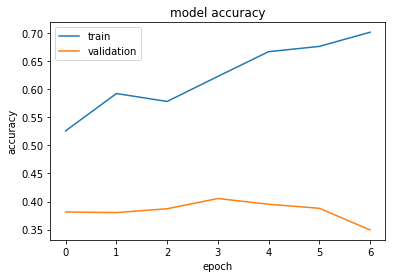

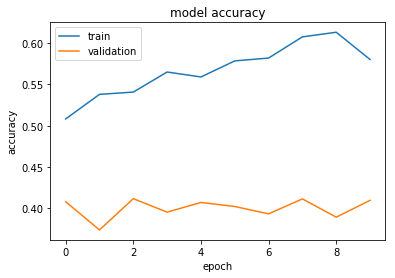

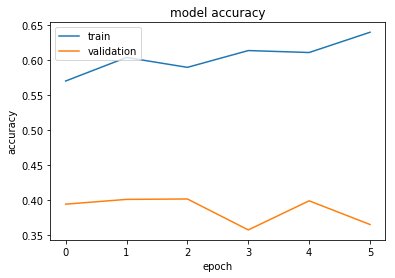

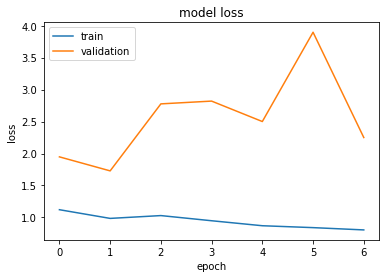

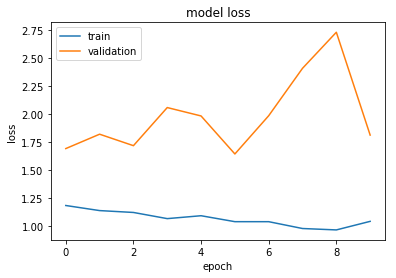

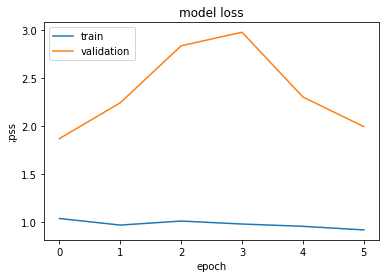

In [0]:
plt.plot(history_ax.history['acc'])
plt.plot(history_ax.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
plt.plot(history_cor.history['acc'])
plt.plot(history_cor.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
plt.plot(history_sag.history['acc'])
plt.plot(history_sag.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history_ax.history['loss'])
plt.plot(history_ax.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
plt.plot(history_cor.history['loss'])
plt.plot(history_cor.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
plt.plot(history_sag.history['loss'])
plt.plot(history_sag.history['val_loss'])
plt.title('model loss')
plt.ylabel(';pss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [11]:
import gc
gc.collect()

0